In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Copy the facenet pretrained weights to cache
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [5]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [6]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [7]:
n_first_frames = 10
n_spaced_frames = 10
pretrained_paths = '../pretrained_models/'
models_root_dir = '../kaggle_datasets/deepfake_2020_03_19/'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=models_root_dir,
                                    third_party_models_directory=pretrained_paths,
                                    n_first_frames=n_first_frames,
                                    n_spaced_frames=n_spaced_frames,
                                    #verbose=2
                                   )

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_02_14-f4
../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_03_12-f2
../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_03_13-f1
../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_03_18_f3
Loaded 0 small face classifier and 4 large face classifier models.
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
Loaded 1 face sequence classifier models.
Loaded 0 second level xgb classifier models and 0 logistic regression models.
##################################################
DeepFakeDetector v.0.7.0
Sample 10 first frames and 10 spaced frames.
Number of max retries is 4
On error cases, predict 0.5
##################################################


In [8]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 130


array(['large_face_clf_mean_0_original_first', 'large_face_clf_max_0_original_first',
       'large_face_clf_std_0_original_first', 'large_face_clf_median_0_original_first', ...,
       'seq_clf_len-5_start-10_0_bright_mean', 'seq_clf_len-5_start-10_0_bright_max',
       'seq_clf_len-5_start-10_0_zoom_mean', 'seq_clf_len-5_start-10_0_zoom_max'], dtype='<U48')

In [9]:
%%time
feats = deepFakeDetector.GetFeatures(filenames[2], p_random_compression=True) # 9008, 43337, 8298
feats

CPU times: user 10.3 s, sys: 233 ms, total: 10.5 s
Wall time: 5.04 s


[array([0.973431, 0.980071, 0.00479 , 0.972455, ..., 0.925375, 0.936079, 0.922467, 0.941315])]

In [10]:
for (feat, name) in zip(feats[0],featNames):
    print(feat, name)

0.9734309250390263 large_face_clf_mean_0_original_first
0.9800711274147034 large_face_clf_max_0_original_first
0.004789990743791605 large_face_clf_std_0_original_first
0.9724552631378174 large_face_clf_median_0_original_first
0.9776453077793121 large_face_clf_Q3_0_original_first
0.9813812256251712 large_face_clf_mean_0_original_spaced
0.9857624769210815 large_face_clf_max_0_original_spaced
0.0042373725240240495 large_face_clf_std_0_original_spaced
0.9830854535102844 large_face_clf_median_0_original_spaced
0.9837661385536194 large_face_clf_Q3_0_original_spaced
0.9147501511512907 large_face_clf_mean_1_original_first
0.9259653687477112 large_face_clf_max_1_original_first
0.011108935062473771 large_face_clf_std_1_original_first
0.9161150455474854 large_face_clf_median_1_original_first
0.9232499897480011 large_face_clf_Q3_1_original_first
0.9253676216086101 large_face_clf_mean_1_original_spaced
0.9520566463470459 large_face_clf_max_1_original_spaced
0.012607152503350224 large_face_clf_std_1

In [11]:
df = df[df['isVal']==True]
df = df[df['cv_fold']<999]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
7,hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
25,sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
26,eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
27,mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
31,kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


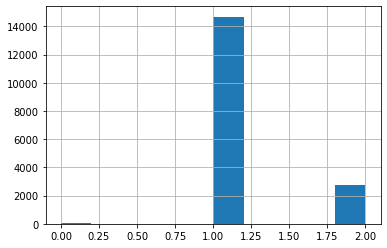

In [12]:
df.person_count.hist()

In [13]:
df.first_person_label.describe()

count    17461.000000
mean         1.539259
std          1.312953
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: first_person_label, dtype: float64

In [14]:
df = df.set_index('index')
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


In [15]:
df_one_person = df[df['person_count']==1]
fake_real_ratio = len(df_one_person[df_one_person['label']=='FAKE']) / len(df_one_person[df_one_person['label']=='REAL'])
print('There are {0:.2} times more fakes'.format(fake_real_ratio))

There are 2.7 times more fakes


In [16]:
MISSING_VAL = 0.5

In [17]:
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


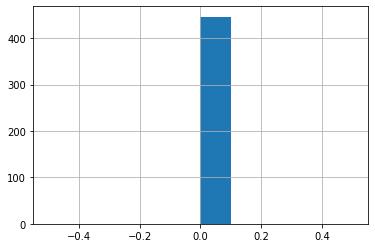

In [18]:
df[df['label']=='REAL'].second_person_label.hist()

In [19]:
from tqdm.notebook import tqdm as tqdm
import random
random.seed(2020)

subsample = 1000

#raw lists
preds_fake = []
preds_real = []

split_fake = []
split_real = []

keys=df.index.values
feat_len = featNames.shape[0]

for i, filename in enumerate(tqdm(filenames)):#[:subsample])):
    if i%500==0: # all garbage is not handled right
        gc.collect()
        
    plain_name = str(filename).split('/')[len(str(filename).split('/'))-1]
    if plain_name not in keys:
        continue
    is_fake = True if df.at[plain_name,'label'] == 'FAKE' else False
    
    #sample fakes the same amount as reals and sample randomly
    if is_fake and random.randint(0,int(round(10*fake_real_ratio))) >= 10:
        continue
    
    split = df.at[plain_name,'cv_fold']
    try:
        preds = deepFakeDetector.GetFeatures(str(filename), p_random_compression=(i%2==0))
    except:
        print("Error with " + str(filename) + ' - ' + str(i))
        if is_fake:
            preds_fake.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_fake.append(split)
        else:
            preds_real.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_real.append(split)
        continue
        
    def _addPred(preds, split, is_fake):
        if is_fake:
            preds_fake.append(preds)
            split_fake.append(split)
        else:
            preds_real.append(preds)
            split_real.append(split)
    
    # preds can have two persons
    if len(preds) > 1:
        continue # skip for now
        # include both
        first_label = df.loc[plain_name]['first_person_label']
        second_label = df.loc[plain_name]['second_person_label']
        if first_label == 0:
            _addPred(preds[0], split, False)
        elif first_label > 0:
            _addPred(preds[0], split, True)
            
        # this assumes the face order is the same
        if second_label == 0:
            _addPred(preds[1], split, False)
        elif second_label > 0:
            _addPred(preds[1], split, True)
    else:
        _addPred(preds[0], split, is_fake)

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/omcyntlcjf.mp4 - 47000
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/tmgmtwznkr.mp4 - 47419
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/uunrfposre.mp4 - 47505
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/xfvjsztftm.mp4 - 47739
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_27/hegucmrlfl.mp4 - 63452
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_30/ttymvnbfdw.mp4 - 71507
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/evpmcvhcpz.mp4 - 74946
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/hqasskuudt.mp4 - 75198
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/jswhgnskzt.mp4 - 75381
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_32/tutdxyfwva.mp4 - 76292
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/ijeocdiijx.mp4 - 111931
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/injpbivosc.mp4 - 111939
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/ipceevmvfn.mp4 - 111942
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/iqovzvsvkn.mp4 - 111949
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/jfczxmooec.mp4 - 112008
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/jhihpqpkmb.mp4 - 112023
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/kamabtemwe.mp4 - 112095
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/kfxetzkzsh.mp4 - 112111
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/kwwveltzqp.mp4 - 112163
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/lhqzgsnvxw.mp4 - 112195
Error with /mnt/945C2D6E5C2D4B

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/zlbwmqopvp.mp4 - 115973
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/achekamhkd.mp4 - 116023
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bvbrngubgv.mp4 - 116091
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/axsgyeohxb.mp4 - 116126
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bclnjhoqol.mp4 - 116149
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bvfxnmejnh.mp4 - 116235
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/cllsklblbu.mp4 - 116303
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/crpmgqavlf.mp4 - 116329
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/dermobcmbu.mp4 - 116393
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/djagudgftt.mp4 - 116417
Error with /mnt/945C2D6E5C2D4B

In [20]:
# is the set balanced?
print(len(preds_real), len(preds_fake))

4053 4020


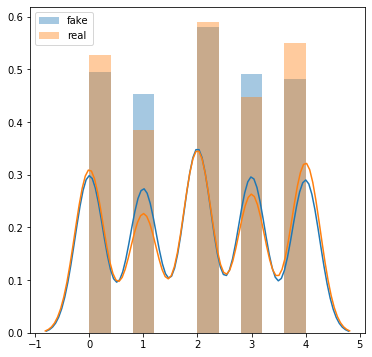

In [21]:
# are the splits balanced?
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(split_fake,bins=10, ax=ax, label='fake')
sns.distplot(split_real,bins=10, ax=ax, label='real')
ax.legend()

# Plot distributions for each feature

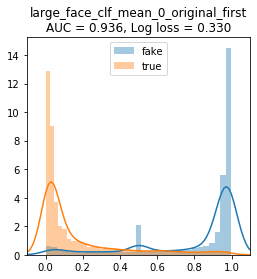

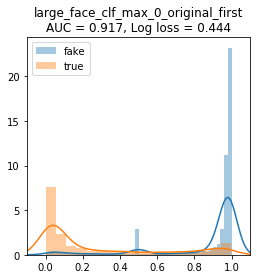

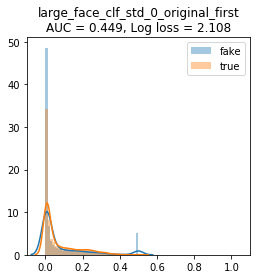

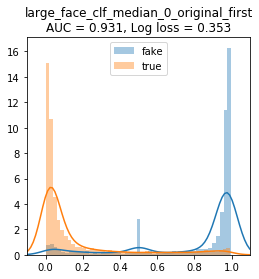

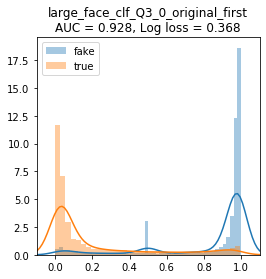

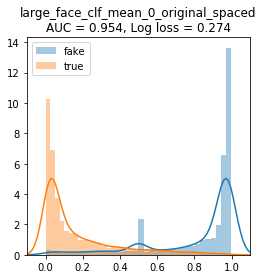

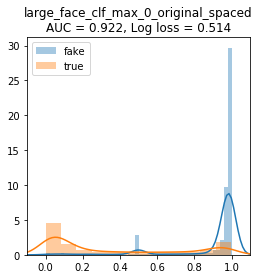

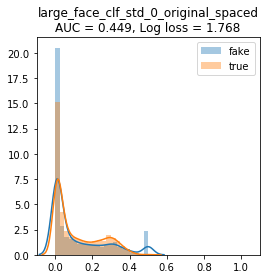

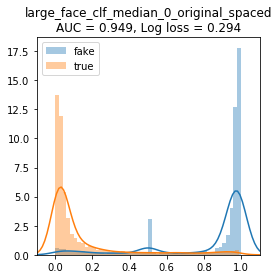

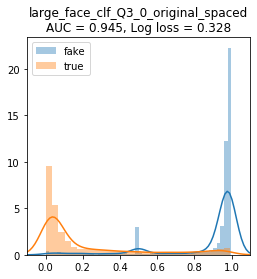

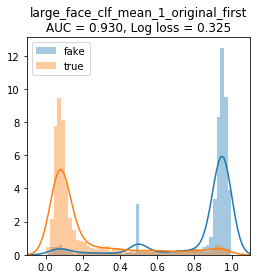

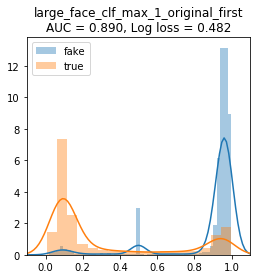

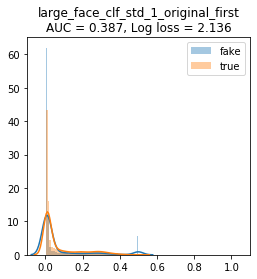

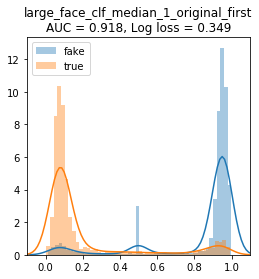

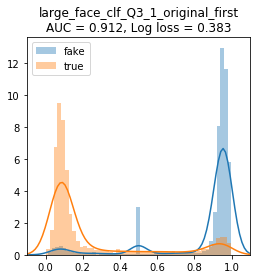

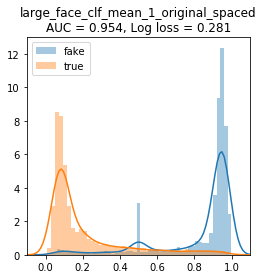

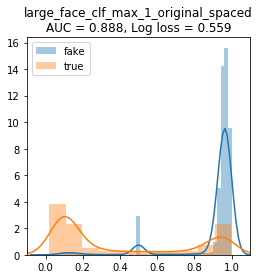

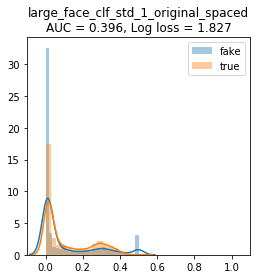

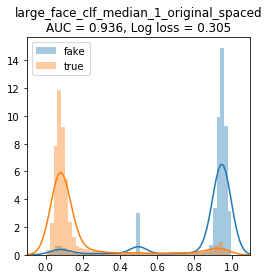

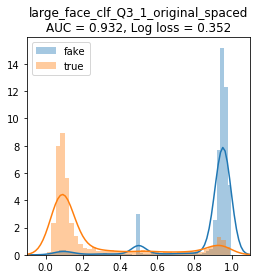

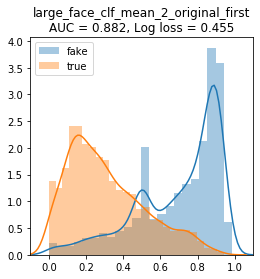

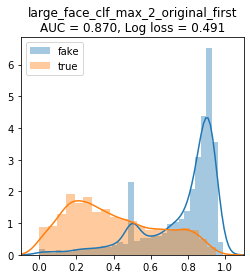

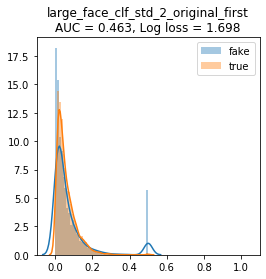

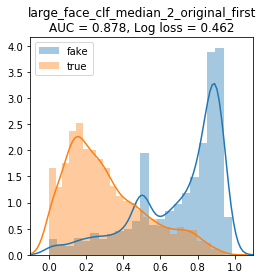

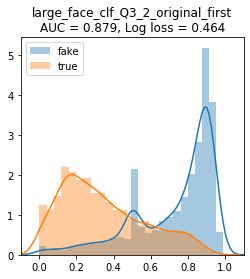

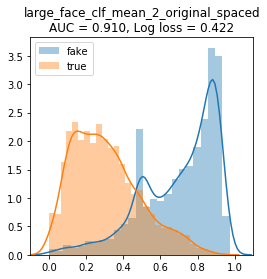

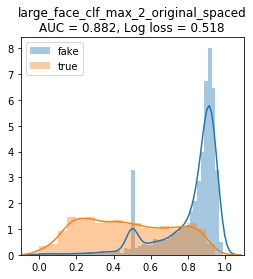

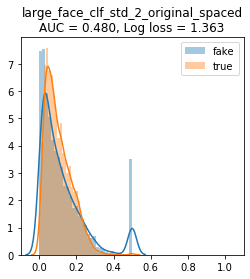

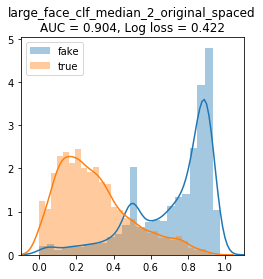

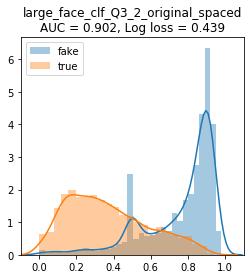

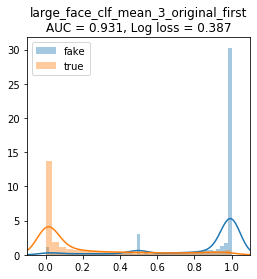

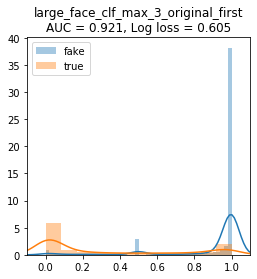

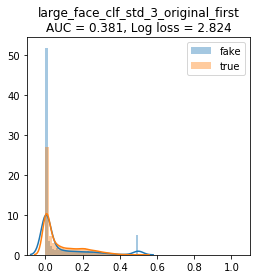

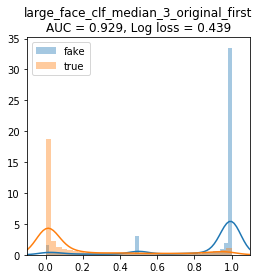

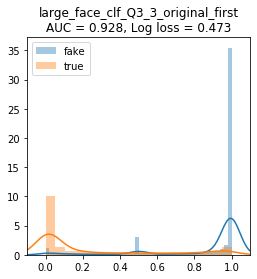

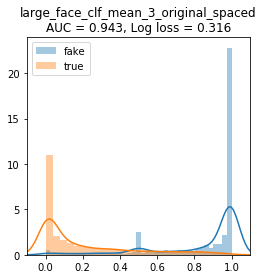

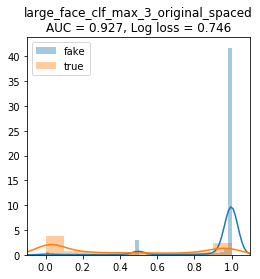

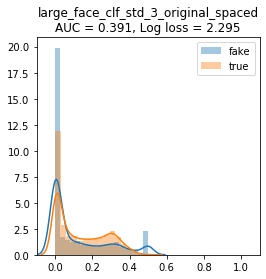

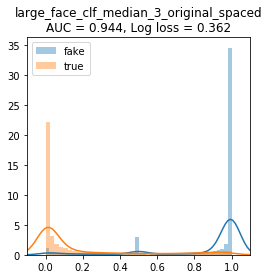

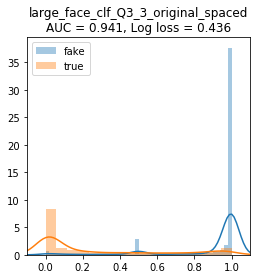

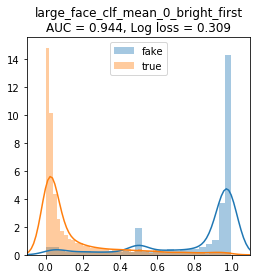

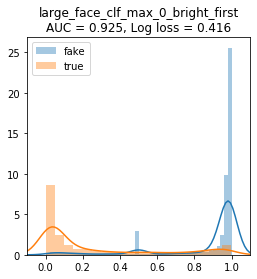

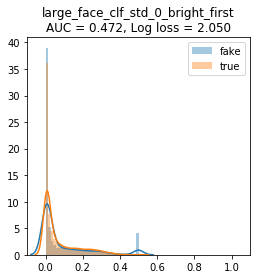

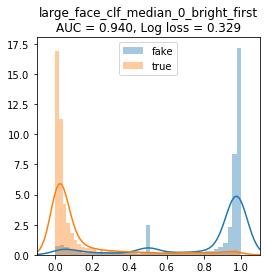

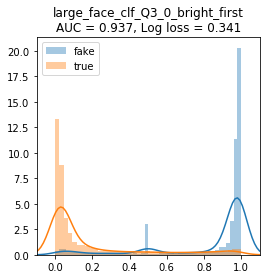

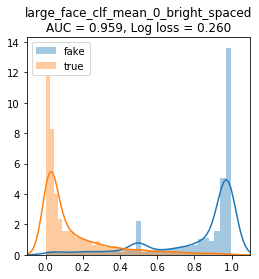

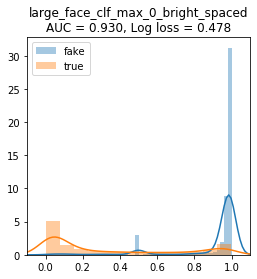

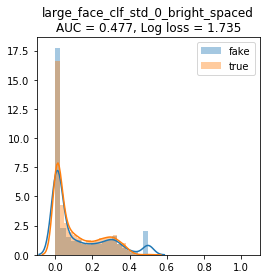

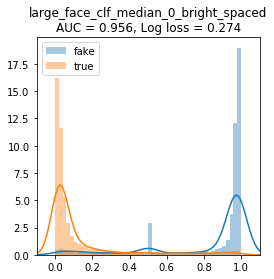

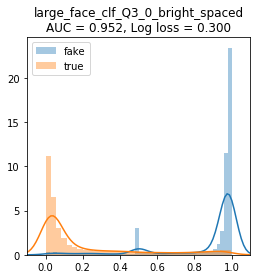

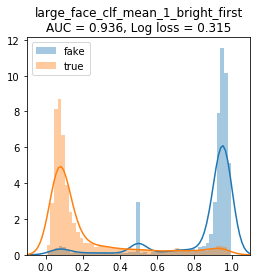

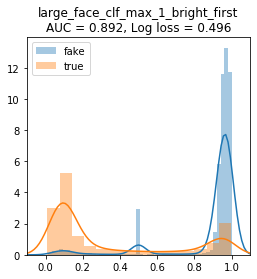

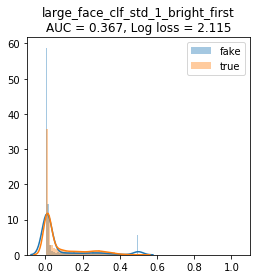

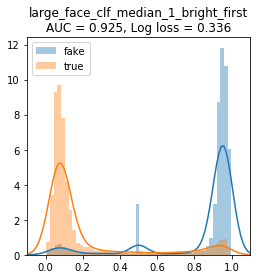

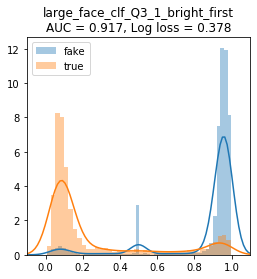

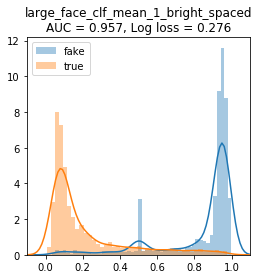

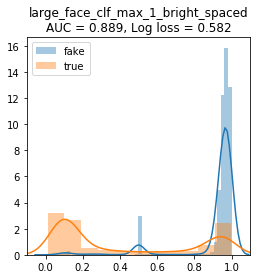

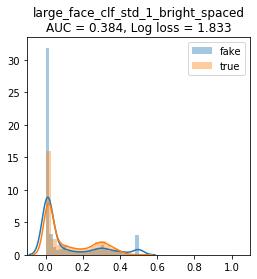

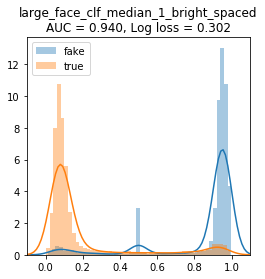

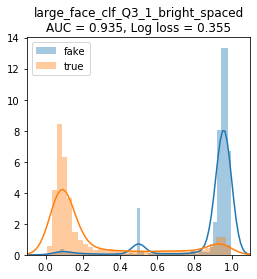

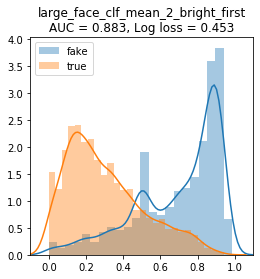

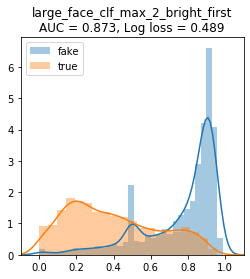

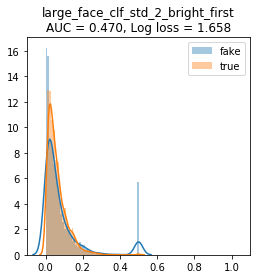

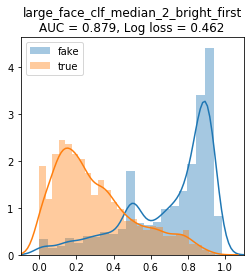

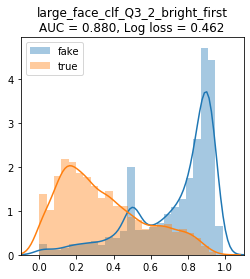

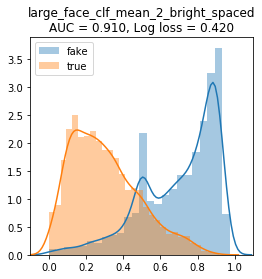

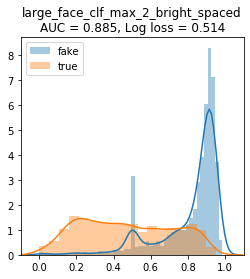

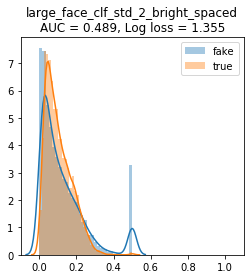

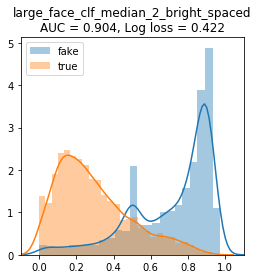

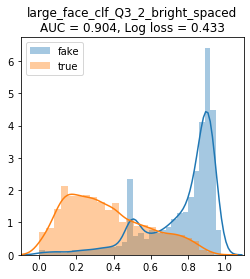

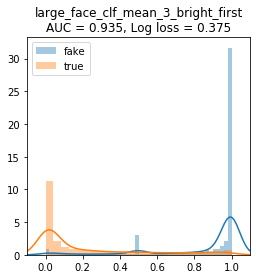

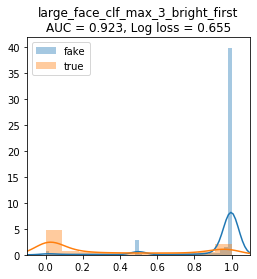

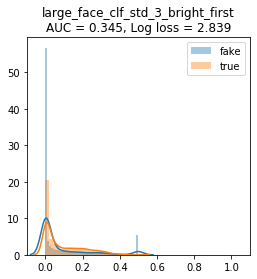

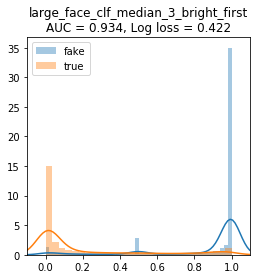

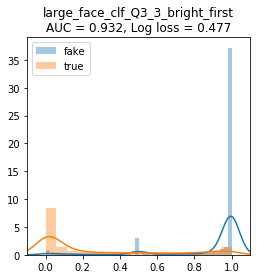

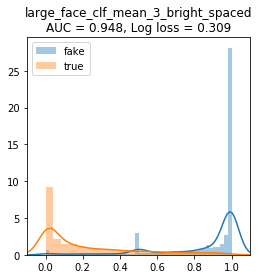

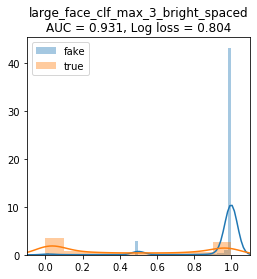

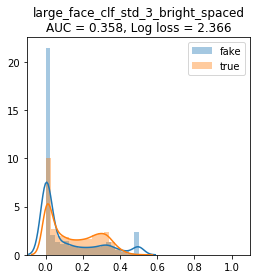

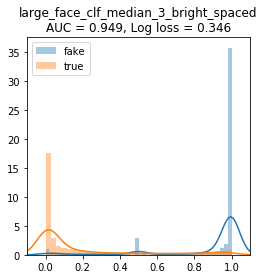

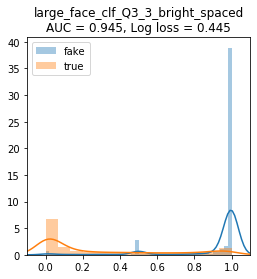

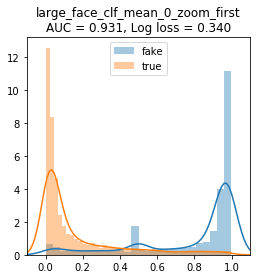

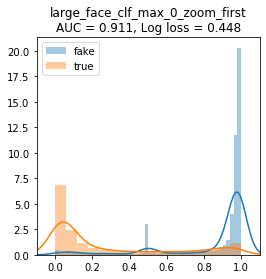

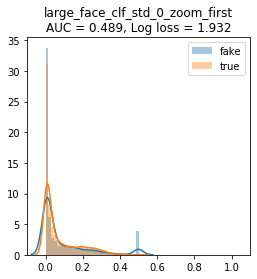

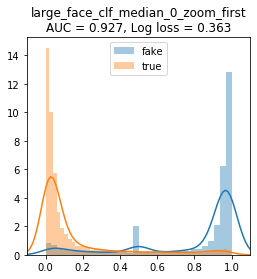

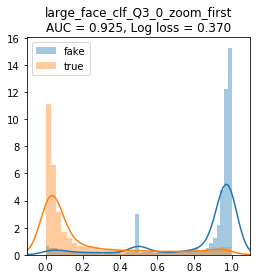

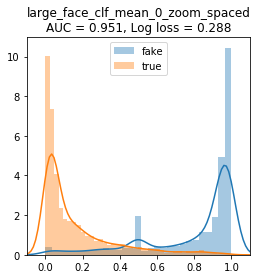

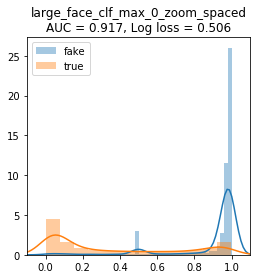

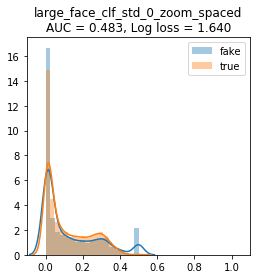

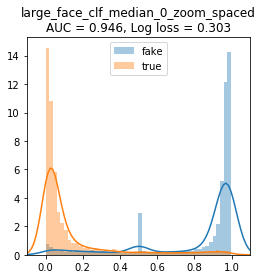

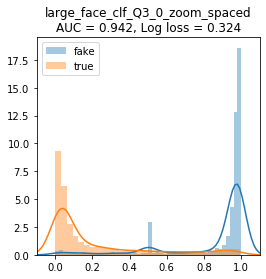

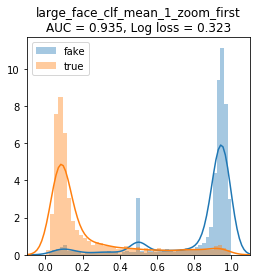

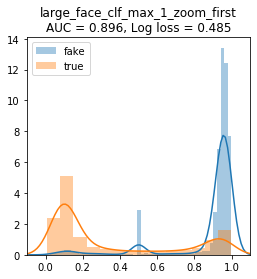

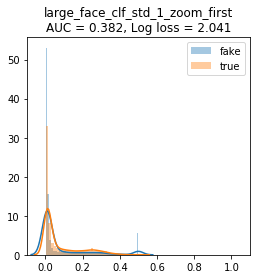

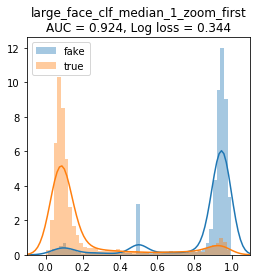

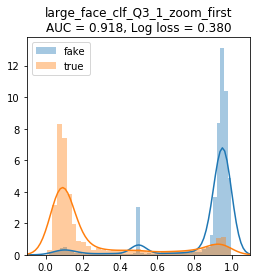

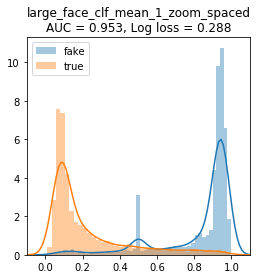

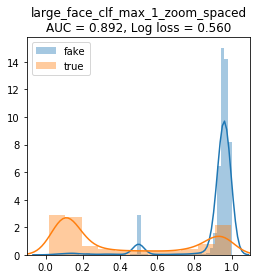

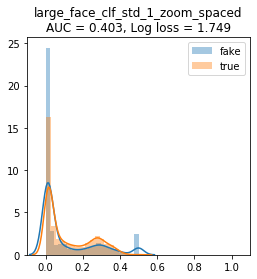

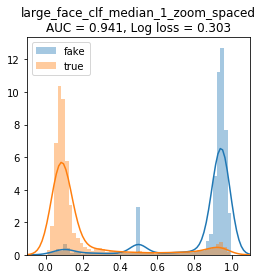

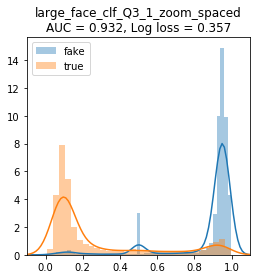

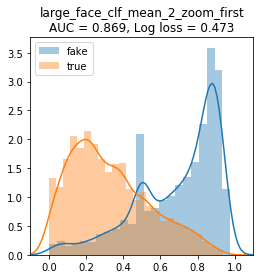

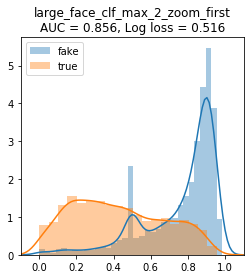

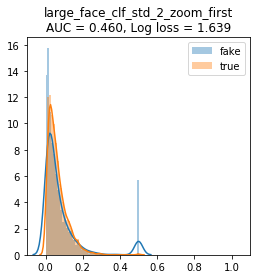

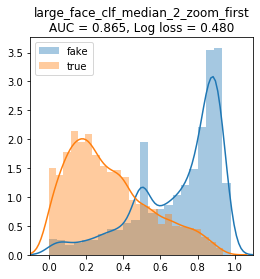

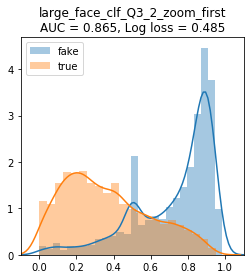

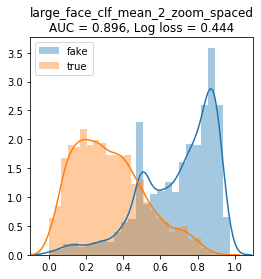

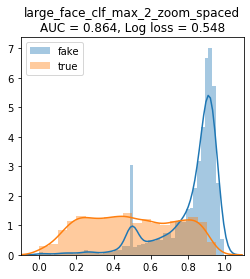

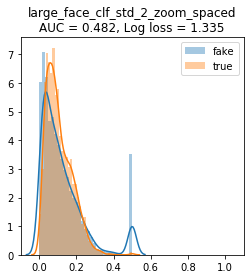

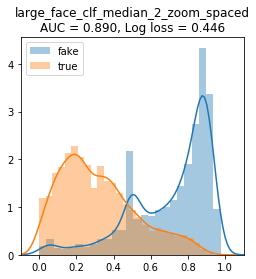

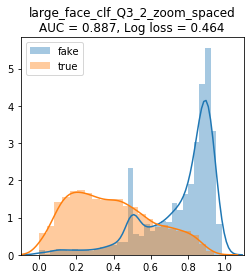

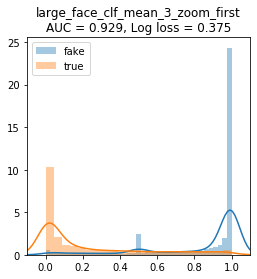

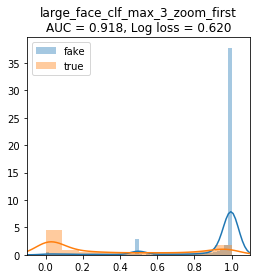

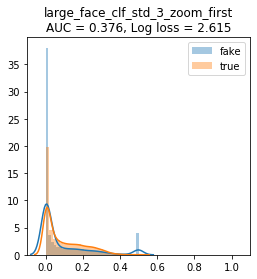

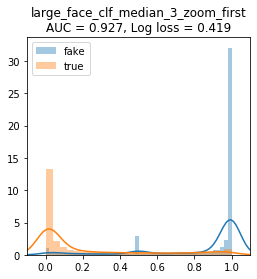

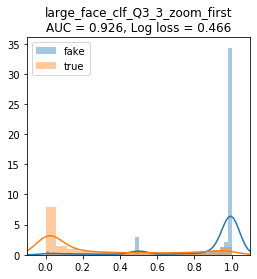

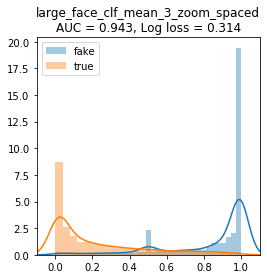

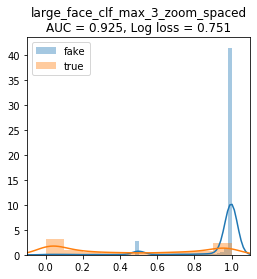

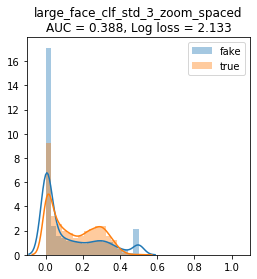

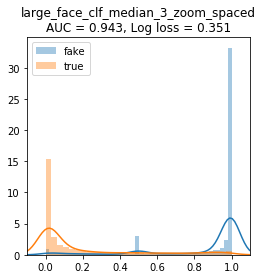

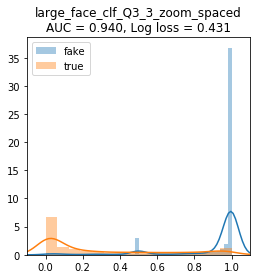

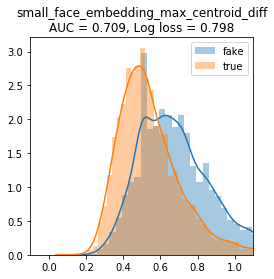

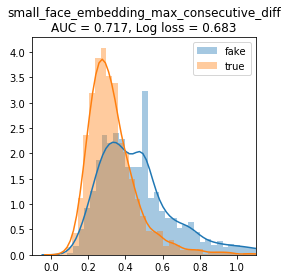

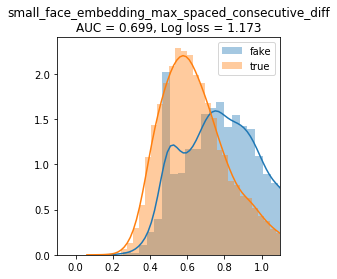

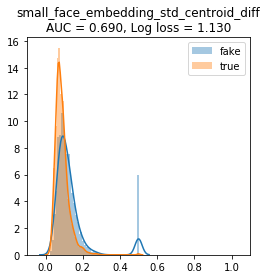

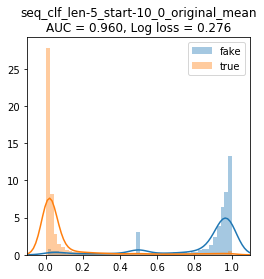

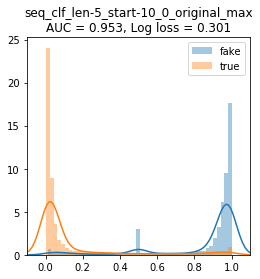

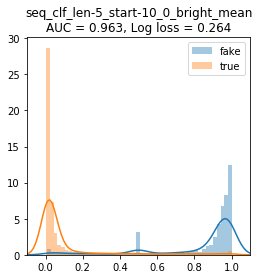

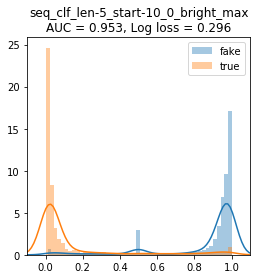

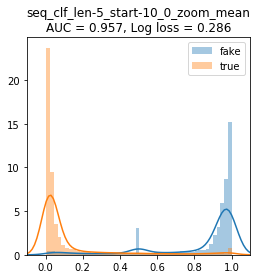

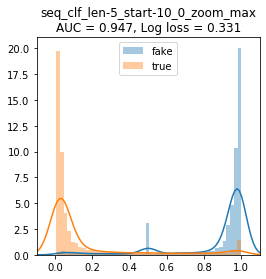

In [22]:
import matplotlib.axes
from sklearn.metrics import roc_auc_score, log_loss

def getAuc(fake_list, real_list):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    return roc_auc_score(true_labels,pred_labels)

def getLogLoss(fake_list, real_list, eps=1e-6):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    # epsilon clip to avoid nans
    pred_labels = np.clip(pred_labels,eps,1-eps)
    return log_loss(true_labels,pred_labels)

def plotFakeReal(feature_index):
    fake_list = list(np.array(preds_fake)[:,feature_index])
    real_list = list(np.array(preds_real)[:,feature_index])
    auc = getAuc(fake_list, real_list)
    logloss = getLogLoss(fake_list, real_list)
    f, ax = plt.subplots(1,1,figsize=(4,4))
    sns.distplot(fake_list, ax=ax, label='fake')
    sns.distplot(real_list, ax=ax, label='true')
    ax.set_title(featNames[feature_index] + '\n' + 'AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
    ax.set_xlim(-0.1,1.1)
    #ax.set_ylim(0,5)
    ax.legend()
    plt.show()

for i in range(preds_fake[0].shape[0]):
    plotFakeReal(i)

# Feature classifier from XGBoost

In [23]:
# collect vectors
ys = np.concatenate([np.ones(len(preds_fake)), np.zeros(len(preds_real))])
xs_fake = np.array(preds_fake)
xs_real = np.array(preds_real)
xs = np.concatenate([xs_fake, xs_real], axis=0)
splits = np.concatenate([split_fake, split_real])
print(ys.shape)
print(xs.shape)
print(splits.shape)

(8073,)
(8073, 130)
(8073,)


In [24]:
# save for later
np.save("./saved_val_xs.npy", xs)
np.save("./saved_val_ys.npy", ys)
np.save("./saved_val_splits.npy", splits)

# Checkpoint

In [26]:
xs = np.load("./saved_val_xs.npy")
ys = np.load("./saved_val_ys.npy")
splits = np.load("./saved_val_splits.npy")

In [25]:
np.unique(splits, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1652, 1353, 1888, 1515, 1665]))

In [26]:
def getSplitParts(fold=0, removeMissing=False):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for x,y,f in zip(xs,ys,splits):
        if(removeMissing and x[0]==MISSING_VAL):
            continue
        if f==999: # error cases
            continue
        if f==fold:
            X_test.append(x)
            y_test.append(y)
        else:
            X_train.append(x)
            y_train.append(y)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [27]:
DIR_SECOND_LEVEL = '../models/second_level_models'
if not os.path.exists(DIR_SECOND_LEVEL):
    os.mkdir(DIR_SECOND_LEVEL)
DIR_EXPERIMENT = os.path.join(DIR_SECOND_LEVEL, '2020_03_19')
if not os.path.isdir(DIR_EXPERIMENT):
    os.mkdir(DIR_EXPERIMENT)

In [46]:
from sklearn.metrics import log_loss
import xgboost as xgb

losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
xgb_models = []
eps = 1e-6
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = "logloss"
    
    model = xgb.XGBClassifier(objective='reg:squarederror',#'binary:logistic', 
                             learning_rate = 0.1, 
                             max_depth = 4,
                             gamma=3,
                             subsample = 0.8,
                             colsample_bytree = 1,
                             reg_lambda=1,
                             reg_alpha=0.3,
                             alpha = 10, 
                             n_estimators = 40,
                             missing=MISSING_VAL)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    model.save_model(str(os.path.join(DIR_EXPERIMENT,'second_level_xgb_{0}.bin'.format(fold))))
    xgb_models.append(model)
    
    y_pred = np.clip(model.predict_proba(X_test)[:,1],eps,1-eps)
    y_pred_train = np.clip(model.predict_proba(X_train)[:,1],eps,1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.137, val_loss: 0.244
Fold 1 train_loss: 0.139, val_loss: 0.205
Fold 2 train_loss: 0.140, val_loss: 0.169
Fold 3 train_loss: 0.138, val_loss: 0.229
Fold 4 train_loss: 0.153, val_loss: 0.130

Mean train_loss 0.141, val_loss 0.195
train loss std 0.006, val loss std 0.041


In [39]:
y_pred

array([0.991512, 0.989058, 0.975859, 0.991512, ..., 0.015502, 0.015502, 0.044745, 0.022334], dtype=float32)

Text(0.5, 1.0, 'Mean loss: 0.194')

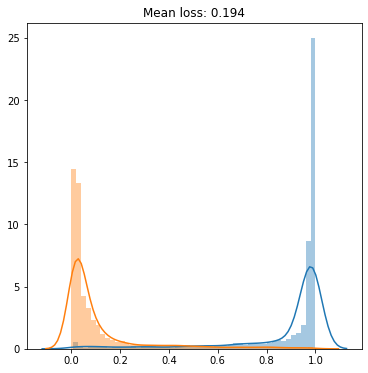

In [40]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

## Weight analysis - eli5

In [41]:
for model in xgb_models:
    display(eli5.explain_weights_xgboost(model, feature_names=featNames))

Weight,Feature
0.2298,large_face_clf_mean_1_bright_spaced
0.2214,large_face_clf_median_1_original_spaced
0.1603,seq_clf_len-5_start-10_0_original_mean
0.0888,seq_clf_len-5_start-10_0_bright_mean
0.0299,large_face_clf_median_1_bright_spaced
0.0297,large_face_clf_median_1_bright_first
0.0289,large_face_clf_Q3_0_bright_spaced
0.0273,large_face_clf_mean_1_bright_first
0.0162,seq_clf_len-5_start-10_0_zoom_mean
0.0083,large_face_clf_median_3_bright_spaced


Weight,Feature
0.2810,seq_clf_len-5_start-10_0_original_mean
0.1600,seq_clf_len-5_start-10_0_bright_mean
0.1560,seq_clf_len-5_start-10_0_zoom_mean
0.1235,seq_clf_len-5_start-10_0_bright_max
0.0249,large_face_clf_median_1_bright_first
0.0163,large_face_clf_mean_1_bright_first
0.0155,seq_clf_len-5_start-10_0_zoom_max
0.0120,large_face_clf_Q3_0_bright_spaced
0.0114,large_face_clf_median_3_bright_spaced
0.0113,large_face_clf_max_3_bright_spaced


Weight,Feature
0.2992,seq_clf_len-5_start-10_0_bright_mean
0.1478,seq_clf_len-5_start-10_0_original_mean
0.1088,seq_clf_len-5_start-10_0_zoom_mean
0.0315,large_face_clf_median_1_bright_first
0.0309,large_face_clf_Q3_1_bright_spaced
0.0301,large_face_clf_mean_0_bright_spaced
0.0276,seq_clf_len-5_start-10_0_zoom_max
0.0235,large_face_clf_Q3_0_bright_spaced
0.0211,large_face_clf_Q3_0_original_spaced
0.0124,large_face_clf_max_3_bright_spaced


Weight,Feature
0.2370,seq_clf_len-5_start-10_0_original_mean
0.2369,seq_clf_len-5_start-10_0_zoom_mean
0.1678,seq_clf_len-5_start-10_0_bright_mean
0.0387,large_face_clf_Q3_3_bright_spaced
0.0247,large_face_clf_mean_0_bright_spaced
0.0168,large_face_clf_Q3_3_original_spaced
0.0161,large_face_clf_median_1_original_spaced
0.0144,large_face_clf_median_1_bright_first
0.0128,large_face_clf_median_3_bright_first
0.0127,large_face_clf_median_3_bright_spaced


Weight,Feature
0.4016,seq_clf_len-5_start-10_0_original_mean
0.2107,large_face_clf_Q3_1_bright_spaced
0.0749,seq_clf_len-5_start-10_0_zoom_mean
0.0445,seq_clf_len-5_start-10_0_bright_mean
0.0332,large_face_clf_median_1_bright_first
0.0205,large_face_clf_Q3_3_original_spaced
0.0177,large_face_clf_mean_0_bright_spaced
0.0171,large_face_clf_Q3_3_bright_spaced
0.0160,large_face_clf_mean_1_bright_first
0.0117,large_face_clf_max_3_bright_spaced


In [42]:
pd.DataFrame({'Variable':featNames,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
124,seq_clf_len-5_start-10_0_original_mean,0.401573
59,large_face_clf_Q3_1_bright_spaced,0.210667
128,seq_clf_len-5_start-10_0_zoom_mean,0.074856
126,seq_clf_len-5_start-10_0_bright_mean,0.044529
53,large_face_clf_median_1_bright_first,0.033187
...,...,...
41,large_face_clf_max_0_bright_first,0.000000
38,large_face_clf_median_3_original_spaced,0.000000
37,large_face_clf_std_3_original_spaced,0.000000
35,large_face_clf_mean_3_original_spaced,0.000000


## Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.externals import joblib
import pickle

In [47]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lr_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    
    clf = LogisticRegression(random_state=0, 
                             max_iter=1000,
                             solver='lbfgs').fit(X_train, y_train)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_LogReg_{0}.sav'.format(fold)))
    #pickle.dump(clf, open(filename, 'wb'))
    #clf = pickle.load(open(filename,'rb'))
    joblib.dump(clf, filename)
    clf = joblib.load(filename)
    lr_models.append(clf)
    
    y_pred = np.clip(clf.predict_proba(X_test)[:,1],eps, 1-eps)
    y_pred_train = np.clip(clf.predict_proba(X_train)[:,1],eps, 1-eps)
    #y_pred = np.clip(y_pred,0.4,1.0)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.149, val_loss: 0.242
Fold 1 train_loss: 0.148, val_loss: 0.228
Fold 2 train_loss: 0.161, val_loss: 0.172
Fold 3 train_loss: 0.148, val_loss: 0.237
Fold 4 train_loss: 0.172, val_loss: 0.118

Mean train_loss 0.156, val_loss 0.199
train loss std 0.010, val loss std 0.048


Text(0.5, 1.0, 'Mean loss: 0.199')

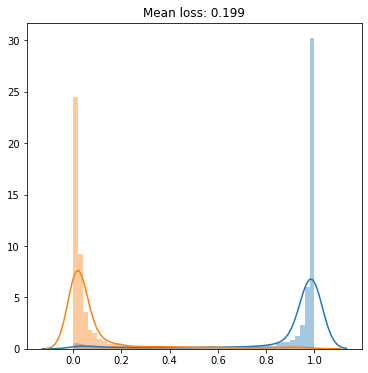

In [48]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

In [49]:
for clf in lr_models:
    display(eli5.explain_weights_sklearn(clf,feature_names=featNames))

Weight?,Feature
+2.741,small_face_embedding_max_consecutive_diff
+1.811,large_face_clf_mean_3_bright_spaced
+1.549,large_face_clf_max_2_original_spaced
+1.482,small_face_embedding_max_spaced_consecutive_diff
+1.456,large_face_clf_mean_0_original_spaced
+1.324,seq_clf_len-5_start-10_0_zoom_max
+1.102,large_face_clf_max_2_bright_spaced
+1.087,large_face_clf_Q3_3_bright_spaced
+1.068,large_face_clf_max_0_bright_spaced
+0.998,large_face_clf_median_3_bright_first


Weight?,Feature
+2.899,small_face_embedding_max_consecutive_diff
+2.438,small_face_embedding_max_spaced_consecutive_diff
+1.735,seq_clf_len-5_start-10_0_bright_mean
+1.669,large_face_clf_max_0_bright_spaced
+1.490,large_face_clf_mean_2_bright_spaced
+1.437,large_face_clf_mean_0_bright_spaced
+1.366,large_face_clf_max_2_bright_spaced
+1.265,seq_clf_len-5_start-10_0_zoom_max
+1.264,large_face_clf_median_1_bright_first
+1.239,large_face_clf_mean_0_original_spaced


Weight?,Feature
+2.929,small_face_embedding_max_consecutive_diff
+1.825,large_face_clf_max_0_bright_spaced
+1.813,small_face_embedding_max_spaced_consecutive_diff
+1.730,large_face_clf_max_2_original_spaced
+1.587,large_face_clf_mean_0_original_spaced
+1.176,seq_clf_len-5_start-10_0_zoom_max
+1.152,large_face_clf_mean_1_bright_first
+1.078,large_face_clf_mean_0_bright_spaced
+1.042,large_face_clf_Q3_3_bright_spaced
+0.914,seq_clf_len-5_start-10_0_bright_mean


Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=1000,\n                   multi_class='warn', n_jobs=None, penalty='l2',\n                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='small_face_embedding_max_consecutive_diff', weight=2.821225037086427, std=None, value=None), FeatureWeight(feature='large_face_clf_max_0_bright_spaced', weight=1.6620349646727808, std=None, value=None), FeatureWeight(feature='seq_clf_len-5_start-10_0_zoom_mean', weight=1.3927865410834717, std=None, value=None), FeatureWeight(feature='large_face_clf_mean_1_bright_first', weight=1.2784410788936325, std=None, value=None), FeatureWeight(feature='seq_clf_len-5_start-10_0_zoom_max', weight=1.241009344580777, std=None, value=None), FeatureWeight(feature='small_face_embedding_max_centroid_diff', weight=1.2391861736611278, std=None, value=None), FeatureWeight(feature='small_face_embedding_max_spaced_consecutive_diff', weight=1.223408938828003, std=None, value=None), FeatureWeight(feature='large_face_clf_Q3_3_bright_spaced', weight=1.162847991350669, std=None, value=None), FeatureWeight(feature='seq_clf_len-5_start-10_0_bright_mean', weight=0.9958384022304152, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-6.8142542367851755, std=None, value=None), FeatureWeight(feature='large_face_clf_std_0_original_spaced', weight=-1.9069426202329183, std=None, value=None), FeatureWeight(feature='large_face_clf_std_0_original_first', weight=-1.5490277825005767, std=None, value=None), FeatureWeight(feature='large_face_clf_std_3_original_spaced', weight=-1.4164058348764912, std=None, value=None), FeatureWeight(feature='large_face_clf_mean_1_zoom_spaced', weight=-1.3490332104962155, std=None, value=None), FeatureWeight(feature='large_face_clf_Q3_2_original_spaced', weight=-1.2885644391347852, std=None, value=None), FeatureWeight(feature='large_face_clf_max_0_zoom_spaced', weight=-1.1403731947306683, std=None, value=None), FeatureWeight(feature='large_face_clf_std_1_bright_spaced', weight=-1.1385904400311473, std=None, value=None), FeatureWeight(feature='large_face_clf_median_2_bright_first', weight=-1.1250753157576394, std=None, value=None), FeatureWeight(feature='seq_clf_len-5_start-10_0_bright_max', weight=-1.1133378649975991, std=None, value=None), FeatureWeight(feature='large_face_clf_std_2_zoom_spaced', weight=-1.0684021497475005, std=None, value=None)], pos_remaining=60, neg_remaining=51), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=1000,\n                   multi_class='warn', n_jobs=None, penalty='l2',\n                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='small_face_embedding_max_consecutive_diff', weight=2.725544119202147, std=None, value=None), FeatureWeight(feature='small_face_embedding_max_spaced_consecutive_diff', weight=2.054512236270753, std=None, value=None), FeatureWeight(feature='large_face_clf_max_0_bright_spaced', weight=1.7435239784691718, std=None, value=None), FeatureWeight(feature='large_face_clf_mean_0_original_spaced', weight=1.4154872043953066, std=None, value=None), FeatureWeight(feature='seq_clf_len-5_start-10_0_zoom_mean', weight=1.3980159499489766, std=None, value=None), FeatureWeight(feature='large_face_clf_mean_2_bright_spaced', weight=1.238999486762726, std=None, value=None), FeatureWeight(feature='large_face_clf_mean_1_bright_first', weight=1.146499924088696, std=None, value=None), FeatureWeight(feature='large_face_clf_max_2_original_spaced', weight=1.1131348994953527, std=None, value=None), FeatureWeight(feature='large_face_clf_max_2_bright_spaced', weight=1.0571439834803533, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-6.447355646579766, std=None, value=None), FeatureWeight(feature='large_face_clf_std_0_original_spaced', weight=-1.9381797011143649, std=None, value=None), FeatureWeight(feature='large_face_clf_Q3_2_original_spaced', weight=-1.7456251424436815, std=None, value=None), FeatureWeight(feature='large_face_clf_max_2_zoom_spaced', weight=-1.5524971377584744, std=None, value=None), FeatureWeight(feature='large_face_clf_Q3_3_original_spaced', weight=-1.1542247082696062, std=None, value=None), FeatureWeight(feature='large_face_clf_std_3_original_spaced', weight=-1.1370379995041573, std=None, value=None), FeatureWeight(feature='large_face_clf_std_2_zoom_spaced', weight=-1.1198908676288502, std=None, value=None), FeatureWeight(feature='large_face_clf_std_0_original_first', weight=-1.1103783744845956, std=None, value=None), FeatureWeight(feature='large_face_clf_median_2_original_spaced', weight=-1.0892287676354264, std=None, value=None), FeatureWeight(feature='large_face_clf_std_1_bright_first', weight=-1.080376061200041, std=None, value=None), FeatureWeight(feature='large_face_clf_std_1_bright_spaced', weight=-1.0435471243854206, std=None, value=None)], pos_remaining=54, neg_remaining=57), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)